In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [18]:
df = pd.read_csv("Iris.csv")
df.label = df.label.map({"Iris-setosa":0,"Iris-versicolor":1,"Iris-virginica":2})
df = df.to_numpy()

num_classes = 3
mask = int(df.shape[0]*0.9)

X_train = df[:mask,:-1]
y_train = df[:mask,-1]

X_test = df[mask:,:-1]
y_test = df[mask:,-1]

print(X_train.shape)
print(X_test.shape)

(135, 4)
(15, 4)


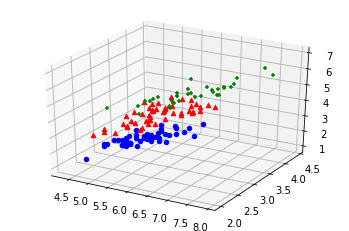

In [28]:
#arrange into matrices
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
classes = {}
colors = ['b', 'r', 'g']
markers = ['o', '^', '+']
for i in range(num_classes):
    indices = np.where(y_train == i)
    temp = X_train[indices]
    for j in temp:
        ax.scatter(j[0],j[1],j[2],c=colors[i], marker = markers[i])
    classes[i] = temp

eigen_values: (4,)
eigen_vectors: (4, 4)
(31.17639534280272+0j)
(0.1975209413136948+0j)
(-2.0146781816697105e-16+9.284510811353966e-17j)


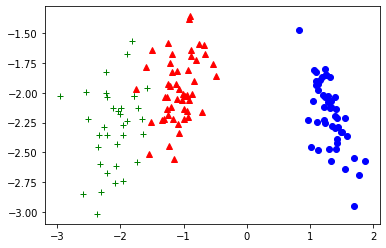

In [31]:
class LDAClassifier:
    # constructor
    def __init__(self, projection_dim):
        self.projection_dim = projection_dim
        self.W = None # weights

    def __compute_means(self, X):
    # Compute the means for each class k = 1,2,3...K
    # If the dataset has K classes, then, self.means_k.shape = [# of records, K]
        means_k = {}
        for idx, input_vectors in X.items():
            means_k[idx] = np.mean(input_vectors, axis=0)
        return means_k
        
    def fit(self, X):
        # get means
        means_k = self.__compute_means(X)
        
        # get indivisual scatters and their sum - within class matrix
        Sks = []
        for idx, mean in means_k.items():
            sub = np.subtract(X[idx], mean)
            Sks.append(np.dot(np.transpose(sub), sub)) # square matrix 

        Sks = np.asarray(Sks)
        SW = np.sum(Sks, axis=0) # shape = (D,D)
        
        # get total mean - M
        count = 0
        sum_all = 0
        for idx, data in X.items():
            count += data.shape[0]
            sum_all += np.sum(data, axis=0)

        M = sum_all / count
        
        # find SB
        SB = []
        for idx, mean in means_k.items():
            sub_temp = mean - M
            SB.append(np.multiply(X[idx].shape[0], np.outer(sub_temp, np.transpose(sub_temp))))

        # between class covariance matrix shape = (D,D). D = input vector dimensions
        SB = np.sum(SB, axis=0)  # sum of K (# of classes) matrices

        # find eigen values and eigen-vectors pairs for np.dot(pinv(SW),SB)
        matrix = np.dot(np.linalg.pinv(SW), SB)
        eigen_values, eigen_vectors = np.linalg.eig(matrix)
        print("eigen_values:", eigen_values.shape)
        print("eigen_vectors:", eigen_vectors.shape)
        
        # make them into tuples and sort in descending order of eigen values
        eiglist = [(eigen_values[i], eigen_vectors[:, i]) for i in range(len(eigen_values))]
        eiglist = sorted(eiglist, key=lambda x: x[0], reverse=True)
        
        # take the first num_dims eigvectors -> eiglist[i][1]
        print(eiglist[0][0])
        print(eiglist[1][0])
        print(eiglist[2][0])
        self.W = np.array([eiglist[i][1] for i in range(self.projection_dim)])
        self.W = np.transpose(self.W)
        
        # multiply every class with each eigenVector
        for idx,data in X.items():
            data = data.dot(self.W)
            for j in data:
                plt.plot(j[0],j[1],c=colors[idx],marker=markers[idx])

clf = LDAClassifier(2)
clf.fit(classes)